# Scaling of Adaptive Behavior in a Toy Model

## Introduction

Modelling in biology faces a difficult crossroads. On one hand we want to use models that are analytical tractable at best and computational tractable at worst, on the other hand we are modelling systems that are fundamentally distributed and decentralized. Even the smallest brain we know of uses 302 neurons which is above the threshold for analytically tractable and depending on levels of biological detail can quickly become computationally untractable. So we are left with a question of how will any of our models work when we start thinking about bigger and bigger brains. 

I don't think there is a universal answer to this question. Most likely it will depend on the fitness landscape of the task and how much we have already understood about the brain. However, I am interested in an example to help clarify my thinking. In this paper I initially tried to provide such an example.

To that end I considered a variant of the Breitenberg phototropism task. I evolved 5 networks of sizes: 2,4,8,16,32 neurons to attach to the same body in the same environment. Their fitness was evaluated on the same task. I then analyzed the agents to determine whether the explanation scales across different brain sizes.

PS: Please run Function Appendix to access all functions used in analysis section.

## Methods
### Evolving Agents

The evolutionary task was adapted from Neil Ni's code. The agents were evolved from a population of 50 over 100 generations. Other parameters were 
- Deme Size: 2
- Mutation Probability: 1/Gene Size
- Recombination Rate: 0.5
- All weight ranges were between [-16,16] with the exception of motor weights which at most could be 1.

The evolutionary run took on average 3 hours on my laptop for all 5 brain sizes. 

In [2]:
import numpy as np                      #Python numerical computational library 
import ctrnn                            #Python Library for simulating CTRNNs (taken from class github)
import matplotlib.pyplot as plt         #Python library for graphing 
import pandas as pd                     #Python library for data manipulation
import neural_braitV_approach as w      #Python library for breitberg task (adapted from Neil Ni)
import feedforward                      #Python library for feedforward neural networks
import pyinform                         #Python library for information theory measures
from mpl_toolkits.mplot3d import Axes3D #Python toolkit for circle plotting

ModuleNotFoundError: No module named 'ctrnn'

### Analysis
To do the analysis I first started by considering one special case of the fitness function when the object was at approximately (3.5,-3.5) or to the bottom right corner of the agent. I then plotted the neural dynamics across all brain sizes.

To see the behavior of the corresponfing agents for this please refer to "{neuron_count}_behavior.png"

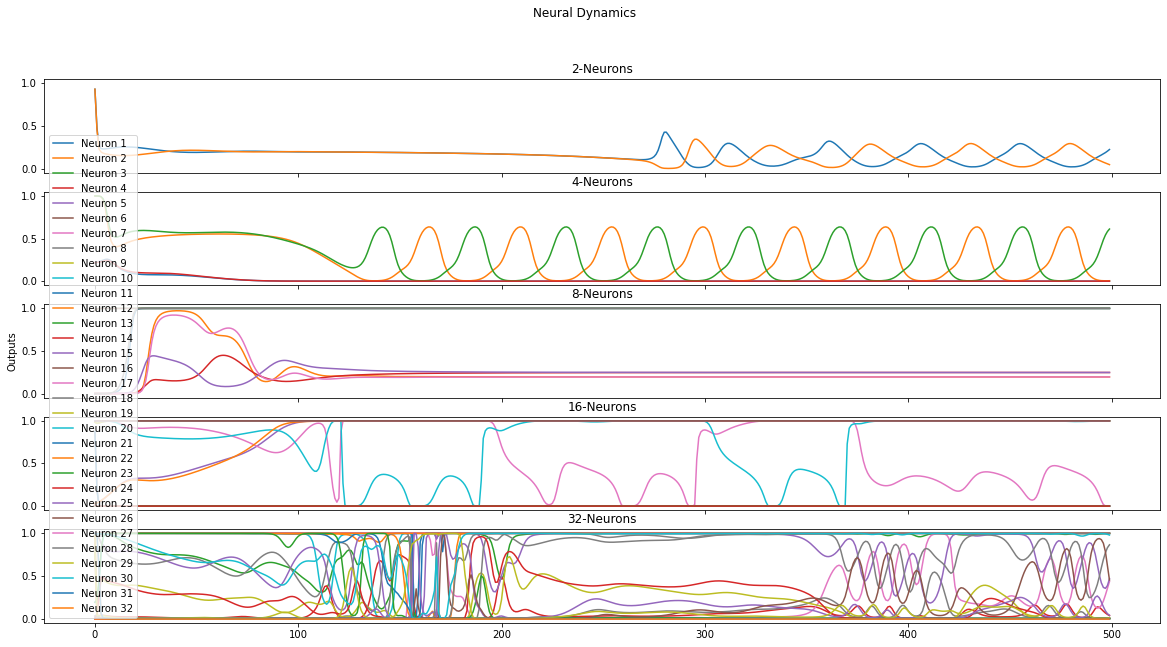

In [34]:
plot_all_neural_dynamics()

Here I see that we can identify three phases of dynamics. Based on my knowledge of the task I would assume this is the orient, approach, and "eat" phases of the behavior. However, these phase boundaries are blurrier for agent 5 (32-neuron).

I also see that in agents with 2,4,16 neurons the first and third phases of the behavior are governed by oscillations. 

For the purposes of this project I will consider only the first phase of the behavior (orientation).

The first step is then to simply look at a quasi static approximation at a range governed by how far the food source will be. Note that since the neurons are symmetric they will follow the same curve since there is not asymmetry induced by the environment. We can observe that the neurons will converge to a stable attractor. We can also see that this will be true regardless of the sensory input. If we go drastically beyond the range of ecologically valid input both neurons will be entirely saturated by the input.

This tells us that the interesting behevaior is not easily understood at the equillibrium and we must analyze the transient to understand the behavior. To do this we will first look at how the network responds to input.

PS: In all of these cases instead of plotting the output of the two neurons directly I am plotting the motor outputs. In the two neuron case this is a simple linear translation and should not cause a qualitative difference. However, it will make visualization easier in the larger brain cases.

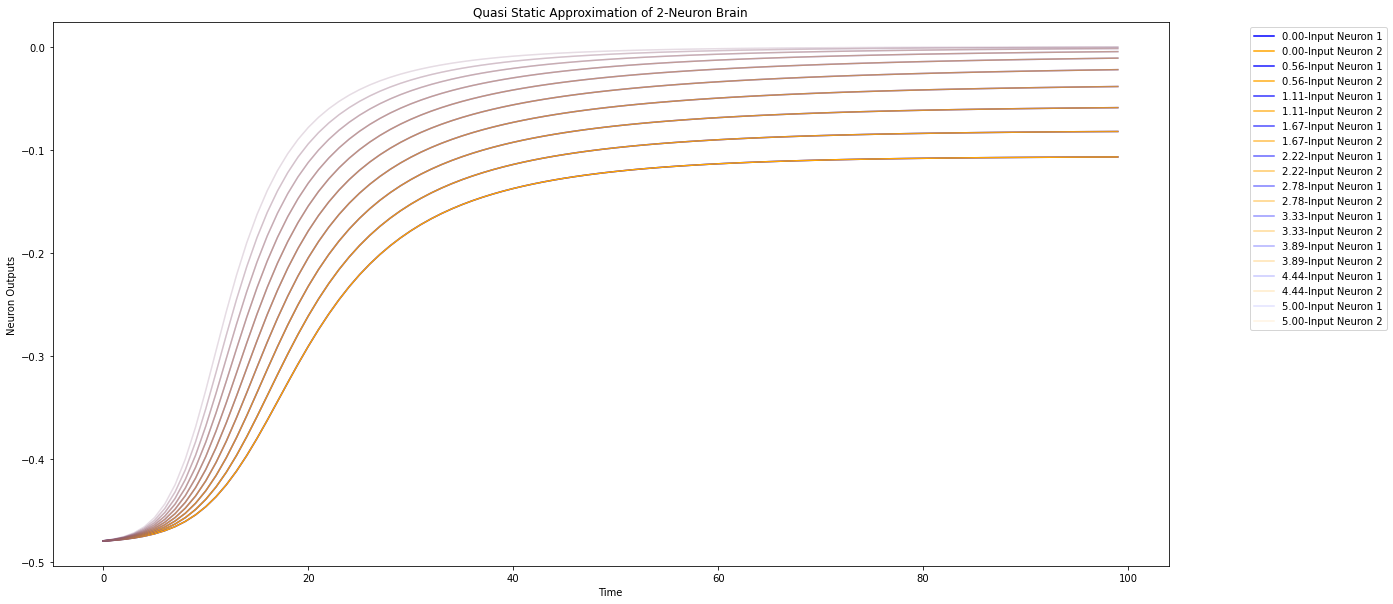

In [26]:
inputs_right = np.linspace(0,5,10)
inputs_left = np.linspace(0,5,10)
inputs = np.stack((inputs_left,inputs_right),1)
trajs = QuasiStaticApproximation(inputs,2)

Since the network is symmetric as we would expect both neurons respond in the same way. Namely as input increases the neurons increase their responses.

This means that when the agent is directly oreinted to stimulus it will produce identitical motor ouputs above 0 which means the agent will go forward. This is exactly what we see in the neural dynamics and behavior of the first phase.

This hints that the first oscillation is not itself related to the approach but must be the orientation phase.

In [655]:
trajs_s = {}

In [1]:
#inputs_right = np.linspace(0.1,5,10)
#inputs_left = np.linspace(0,4.9,10)
#inputs = np.stack((inputs_left,inputs_right),1)
for j in [1,2,3,4,5]:
    mis = []
    if j in trajs_s:
        trajs = trajs_s[j]
        continue
    for i in [2,3,4,5]:
        inputs = get_input_vectors(i,extent=91)
        mis.append(inputs)
    trajs = MultiQuasiStaticApproximation(mis,2**j,steps=2000)
    trajs_s[j] = trajs

NameError: name 'trajs_s' is not defined

In [637]:
del trajs_s[5]

In [658]:
for j in trajs_s:
    trajs_s[j] = np.array(trajs_s[j])

In [641]:
print(trajs_s[1].shape)

(4, 90, 700, 2)


2


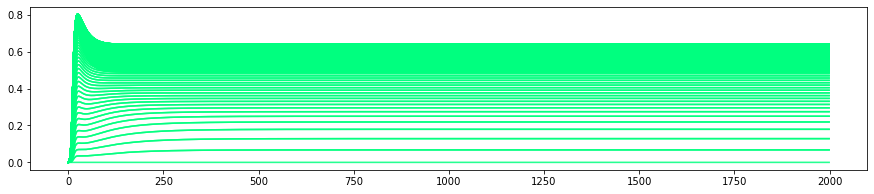

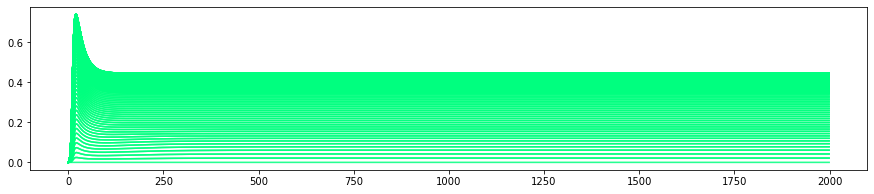

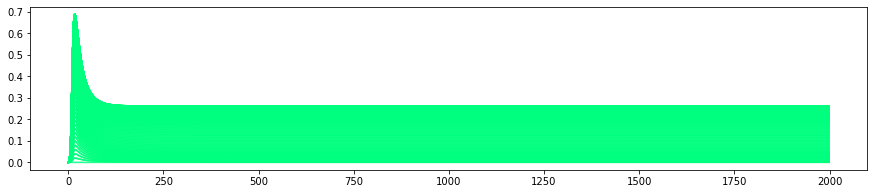

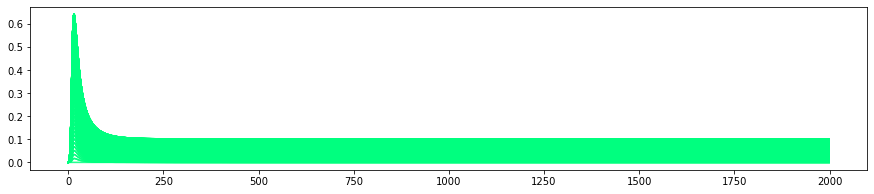

4


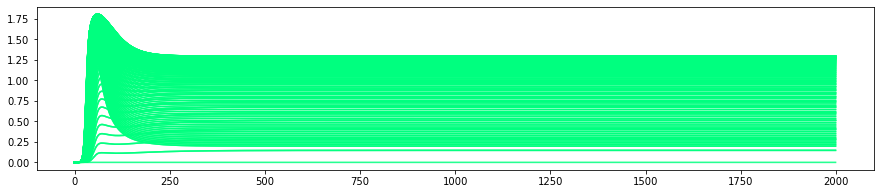

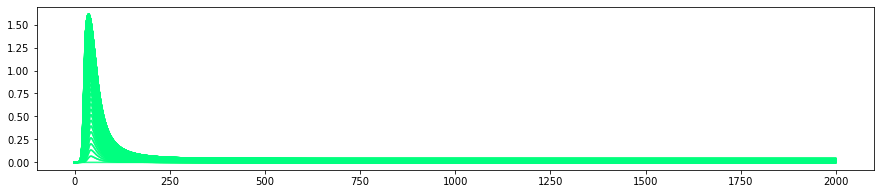

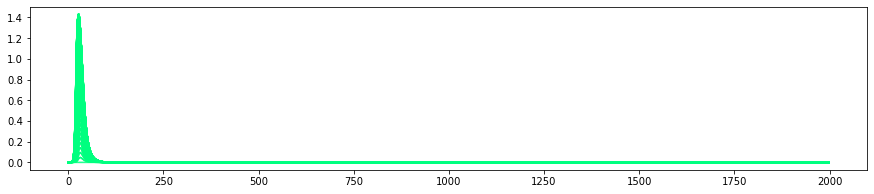

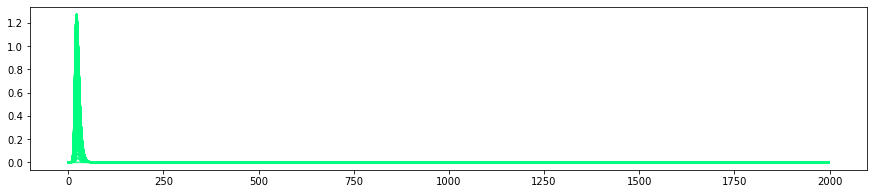

8


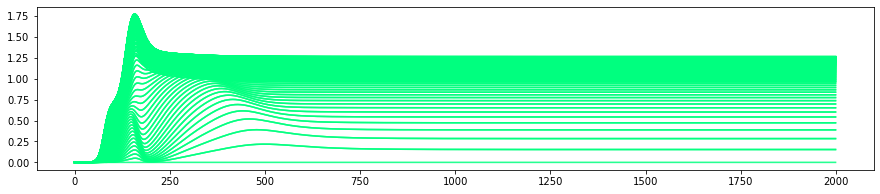

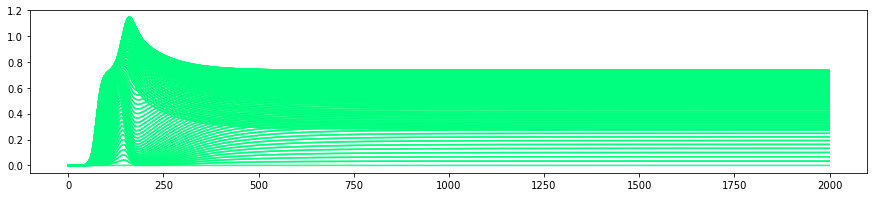

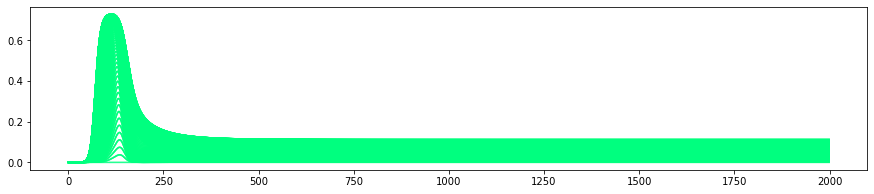

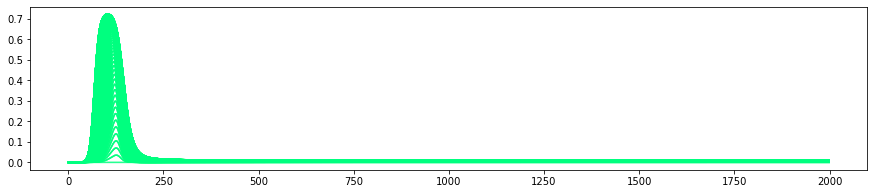

16


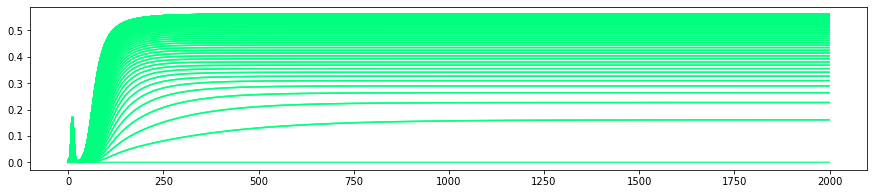

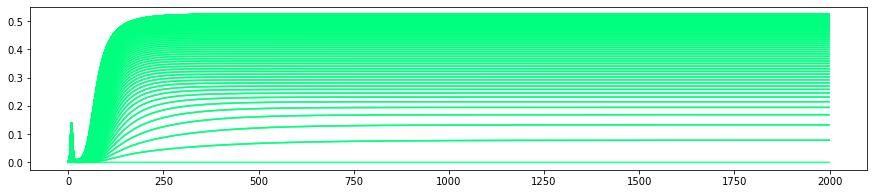

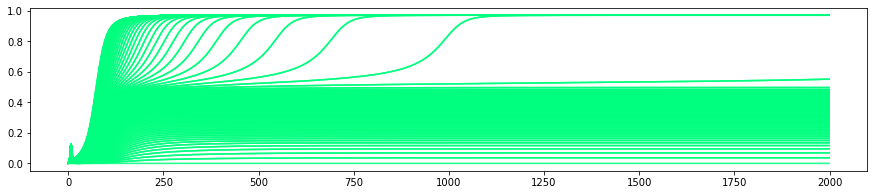

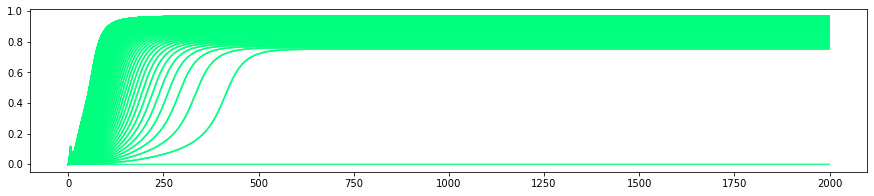

32


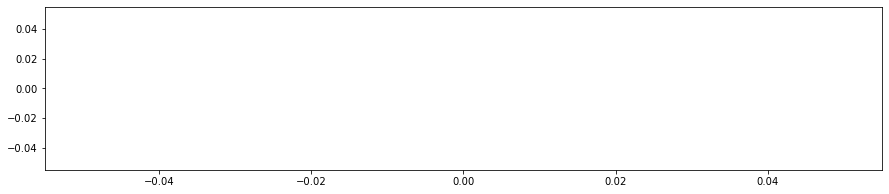

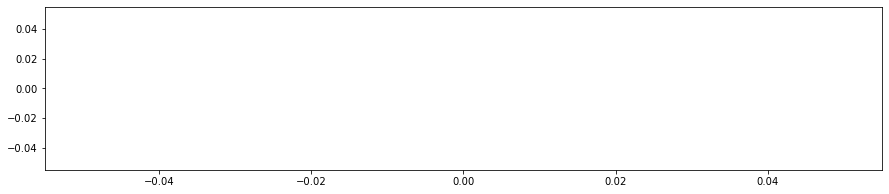

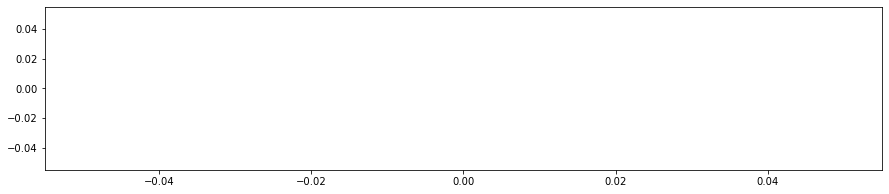

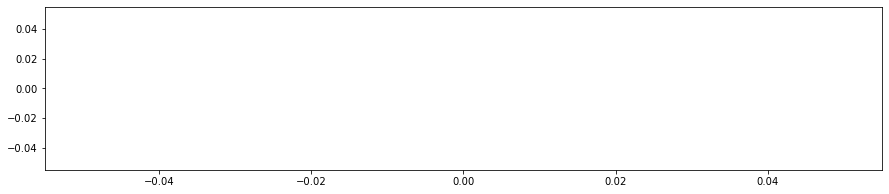

In [659]:
for key in trajs_s:
    trajs2 = trajs_s[key]
    print(2**key)
    for d, distance in enumerate(trajs2):
        plt.figure(figsize=(15,3))
        for i, angle in enumerate(trajs2[d]):
            if key == 5:
                l = np.abs(trajs2[d,i,8000:,0] - trajs2[d,i,8000:,1])
            else:
                l = np.abs(trajs2[d,i,:2000,0] - trajs2[d,i,:2000,1])
            plt.plot(l,color="springgreen",alpha=1-i/400)
            #plt.plot(trajs2[d,i,:,1],color="magenta",alpha=1-i/400)
        plt.show()

In [ ]:
for key in trajs_s:
    trajs2 = trajs_s[key]
    print(2**key)
    for d, distance in enumerate(trajs2):
        plt.figure(figsize=(15,3))
        for i, angle in enumerate(trajs2[d]):
            if key == 5:
                l = np.abs(trajs2[d,i,8000:,0] - trajs2[d,i,8000:,1])
            else:
                l = np.abs(trajs2[d,i,:2000,0] - trajs2[d,i,:2000,1])
            np.trapz(l,dx=0.001)
            plt.plot(l,color="springgreen",alpha=0.1)
            #plt.plot(trajs2[d,i,:,1],color="magenta",alpha=1-i/400)
        plt.show()

To test this hypothesis we can feed the agent inputs differentially on each sensor. Since the agent is symmetric we should be able to stimulate only the right side without loss of generality. Which we do above.

We see in this case that the environmentally asymmetry led to asymmetry in the neural dynamics. We are now able to distinguish how the different respond to the sensors. Neuron 2 goes up as the right sensor increases and neuron 2 goes down in terms of firing rate. We cannot conclude the sensor weights directly because of non-linearites and recurrence but we can see that the agent orients to a stimulus on the right by reducing activity in one neuron and increasing activity in the other. 

Thus we test this prediction by plotting the agents orientation over time below.

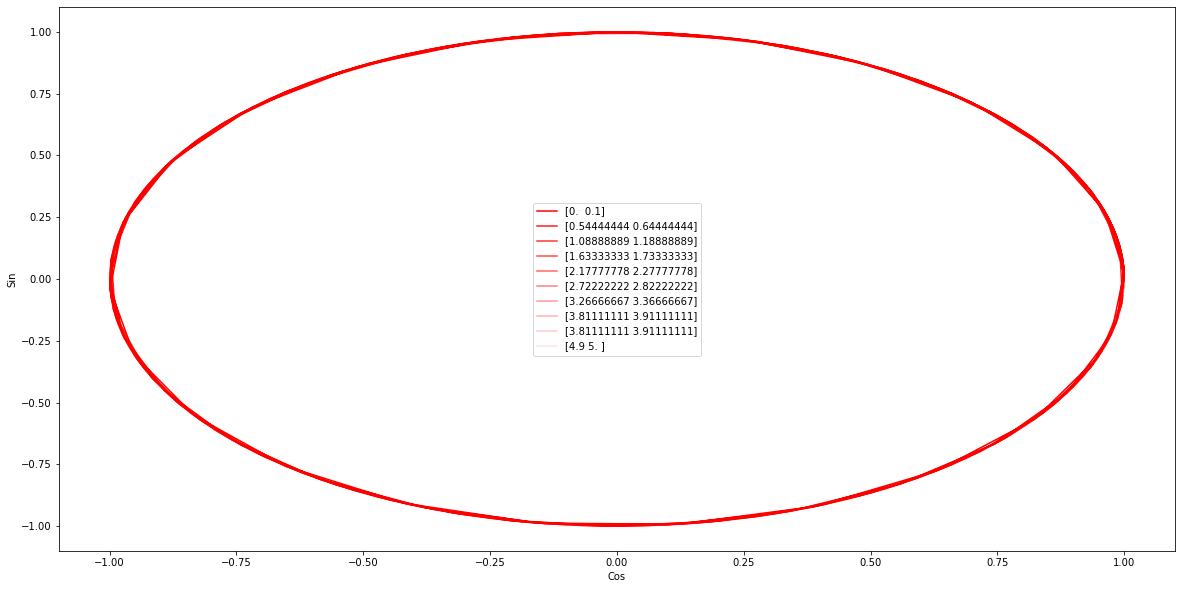

In [28]:
alpha_index = 0
for traj in trajs:
    i = alpha_index * 10
    i = int(i)
    plt.plot(np.cos(traj),np.sin(traj),color="red",alpha=1-0.99*alpha_index,label=f"{inputs[i]}")
    alpha_index += 0.1
plt.ylabel("Sin")
plt.xlabel("Cos")
plt.legend()
plt.show()

Looking at the behavior we confirm the basic story above. One complication is that the size of the input seems to affect the duration of the transient although the basic behavior is the same.

Now we can conclude what is causing the oscillations. The oscillation is caused by the asymmetry of the input which itself is a result of the asymmetric orientation of the agent to the light source. The agent turns and this is reflected in the rise of one neruon but the turn is too much and the other neuron now becomes dominant which turns in the reverse direction and so on. However since the agent is also changing positions the total distance decreases which then leads to long and longer transients and thus larger and larger turns. This is why instead of continuing indefinitely the the oscillations stabalize. If this story is true we should be able to cause constant oscilation in the neural dynamics by hodling the agent still and rotating the object around the agent.

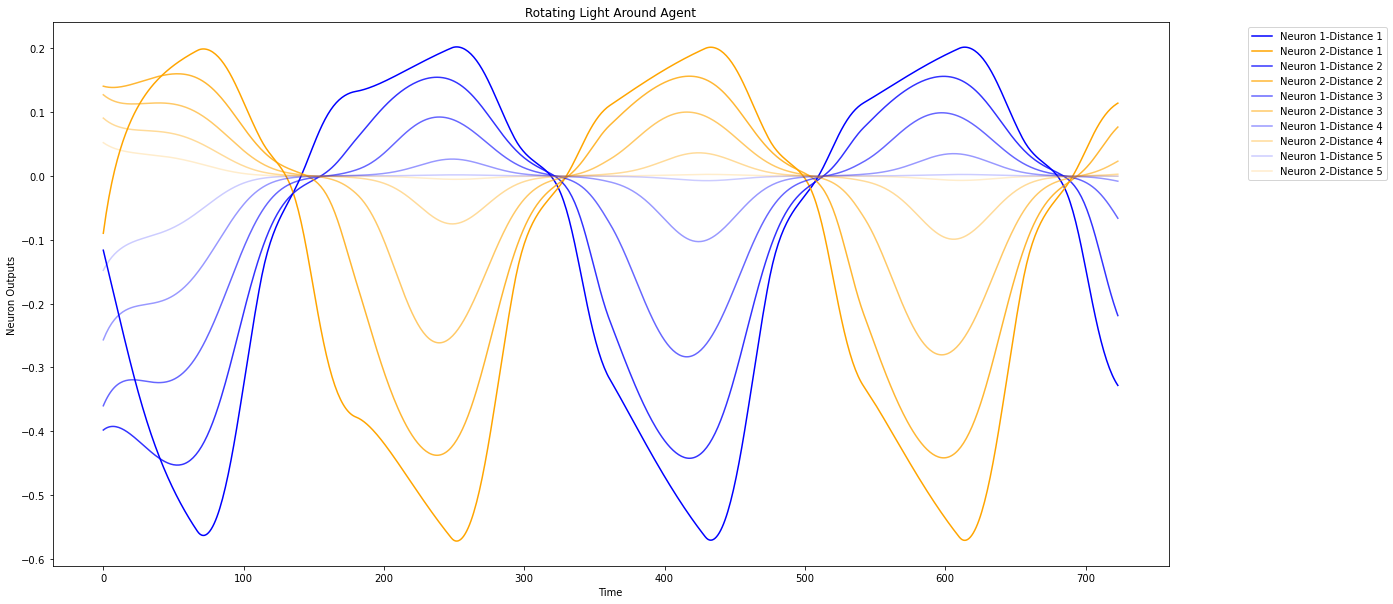

In [63]:
t = tease_agent([1,2,3,4,5],2)

Here we hold the agent in place but rotate the object around it. We hold the object at a constant distance from the agent specified in the legend.

As expected this creates an oscillation. However my initial hypothesis was too simplistic. The overcompensation mechanism is in part caused by the absolute magnitude of the distance. We can see this by the wave size of the oscillations across different input distances, however even within a given test trial we see the size of the oscillations vary which means that the agent also relies on its interal dynamics to control oscillation period.

More interpretabily the agent doesn't just make bigger turns if the object is closer but also assumes that after a fixed number of turns it should turn less. This means that the agent uses not only environmental cues but also how it "feels" to inform its behavior.

Although my initial goal was to analyze both the orientation and the stay behavior I found that the orientation behavior itself was sufficiently complicated even in a two neuron agent. So instead of further analyzing the same agent for this project I will compare orientation strategies in the other agents as well. To do this we will apply the tease agent analysis across all brain sizes. Instead of plotting the neural dynamics directly however we will plot the motor outputs.

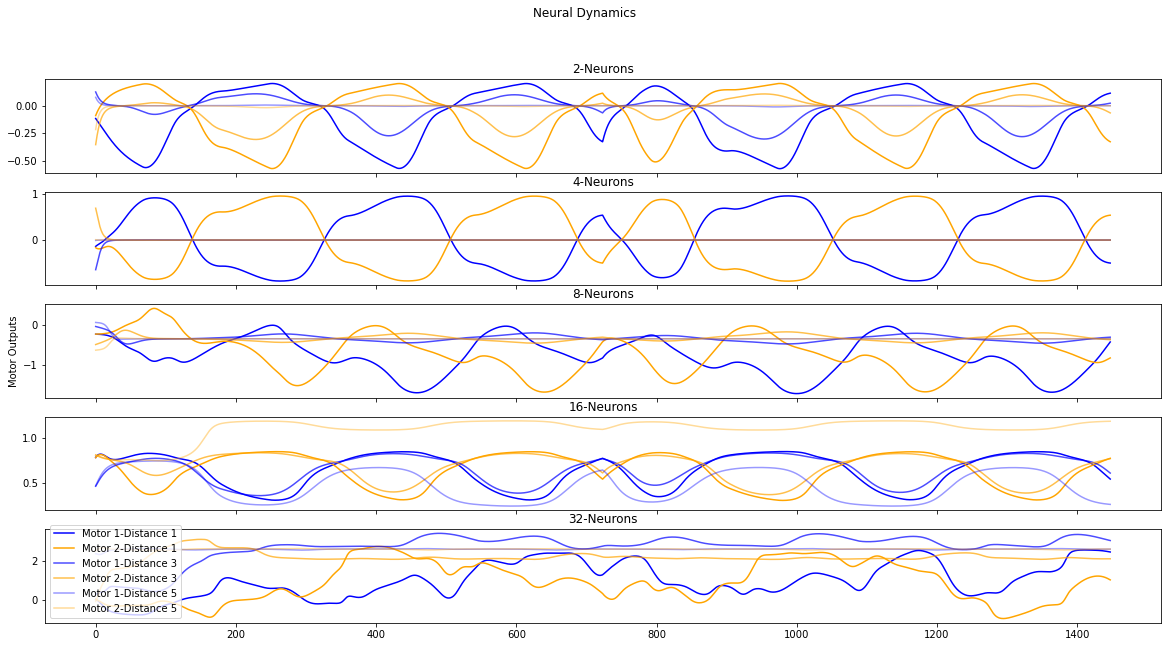

In [30]:
t = tease_agents(distances=[1,3,5])

Comparing the resulting motor outputs during the fixed rotation test we see that resulting dynamics for the agents are similar in that in every case the oscillation has a smaller peak as the simulus gets further. So the agent makes subtler turns when the object is further away however we see that the reliance on internal dynamics seems to a bigger deal in some agents than others. In the case of the 32 neurons we see basically qualitatively different behavior after testing the agent for long enough.

This analysis is far from complete however we can start to draw some conclusions.

## Conclusion
In this project I compared the orientation behavior of various breitenberg agents as we increased the size of their brain. There were three important conclusions to draw from these results. Firstly that even in the most simple case we see the emergence of multi-causality. The agent relies not only on external stimuli but its own internal dynamics as well to inform behavior. The second thing we see is that as agents get more and more complicated brains the reliance on internal dynamics seems to increase. Intuitively this makes sense. If the agent has a bigger brain it will rely on parts of its brain to inform the behavior more. The third conclusion we can see in the fact that oscillations exist in during the teasing test. This tells us although as brains get bigger and internal dynamics get more complicated since the agent is selected for based on certain behaviorial markers we will be able to see those behaviorial markers emerge in the brain dynamics regardless of brain size.

All in all we can conclude that as brains get bigger the problem gets more complicated however looking at smaller brains can help us find what to look for and behavior can constrain the scope of the problem.

## Bibliography
1. Beer, R.D. (1995). On the dynamics of small continuous-time recurrent neural networks. Adaptive Behavior 3:469-509.
2.  V. Braitenberg, Vehicles. Experiments in synthetic psycology. The MIT Press, 1984

## Appendix Functions

### Plot all neural dynamics
Generates 5 stacked plots of neural dynamics during single instance of behavior

In [4]:
def plot_all_neural_dynamics(folder="./Run2/"):
    fig, axs = plt.subplots(5, sharex=True, sharey=True, figsize=(20,10))
    fig.suptitle('Neural Dynamics')
    for i in range(1,6):
        ni = 2 ** i
        df = np.load(folder + f"{ni}_neuron_trajectory.npy")
        df = df[:,0,:]
        if i == 3:
            axs[i-1].set_ylabel("Outputs")
        axs[i-1].set_title(f"{ni}-Neurons")
        for j in range(df.shape[1]):
            axs[i-1].plot(df[:,j],label=f"Neuron {j+1}")
    plt.legend(loc="lower left")
    plt.show()

### Quasistatic Approximation
Generates a plot of quasi static approximations given a CTRNN and vector of inputs

In [5]:
def QuasiStaticApproximation(inputs,n=2,legend=False):
    agent, mw, sw = get_agent(n)
    trajectories = []

    N = n
    HN = int(N/2)
    gs = HN * N + HN + N + HN
    alpha_index = 0

    for inp in inputs:
        trajectories.append([])
        activations = []
        agent.Inputs = np.dot(inp,sw)
        agent.initializeState(0)
        body = w.Agent(np.ones(gs))
        food = w.Food(0,0)
        for i in range(100):
            agent.step(0.01)
            motorout = np.dot(agent.Outputs,mw)
            body.step(food, motorout, 0.01)
            activations.append(motorout)
            trajectories[-1].append(body.orient())
        activations = np.array(activations)
        plt.plot(activations[:,0],alpha=1-0.99*alpha_index,color="cyan", label=f"{inp[0]:.2f}-Input Neuron 1")
        plt.plot(activations[:,1],alpha=1-0.99*alpha_index,color="magenta",label=f"{inp[1]:.2f}-Input Neuron 2")
        alpha_index += 1/inputs.shape[0]
    
    if legend:
        plt.legend(bbox_to_anchor=(1.2, 1))
    plt.rcParams["figure.figsize"] = (20,10)
    plt.title("Quasi Static Approximation of 2-Neuron Brain")
    plt.ylabel("Neuron Outputs")
    plt.xlabel("Time")
    plt.show()
    return trajectories

In [614]:
def MultiQuasiStaticApproximation(multiinputs,n=2,legend=False,steps=500):
    agent, mw, sw = get_agent(n)
    trajectories = []
    rv = []
    fig, axs = plt.subplots(len(multiinputs), sharex=True, sharey=False, figsize=(20,10))
    N = n
    HN = int(N/2)
    gs = HN * N + HN + N + HN
    alpha_index = 0
    
    for j, inputs in enumerate(multiinputs):
        rv.append([])
        for inp in inputs:
            rv[-1].append([])
            trajectories.append([])
            activations = []
            agent.Inputs = np.dot(inp,sw)
            agent.initializeState(0)
            body = w.Agent(np.ones(gs))
            food = w.Food(0,0)
            for i in range(steps):
                agent.step(0.01)
                motorout = np.dot(agent.Outputs,mw)
                body.step(food, motorout, 0.01)
                rv[-1][-1].append(motorout)
                activations.append(motorout)
                trajectories[-1].append(body.orient())
            activations = np.array(activations)
            axs[j].plot(activations[:,0],alpha=1-0.99*alpha_index,color="cyan", label=f"{inp[0]:.2f}-Input Neuron 1")
            axs[j].plot(activations[:,1],alpha=1-0.99*alpha_index,color="magenta",label=f"{inp[1]:.2f}-Input Neuron 2")
            
            alpha_index += 1/inputs.shape[0]

        if legend:
            axs[j].legend(bbox_to_anchor=(1.2, 1))
        #plt.rcParams["figure.figsize"] = (20,10)
        #plt.title("Quasi Static Approximation of 2-Neuron Brain")
        axs[j].set_ylabel("Neuron Outputs")
        axs[j].set_xlabel("Time")
    plt.show()
    return rv

In [ ]:
def plot_multi_quasi_static

### Tease Agent
In this function we hold the position of the agent constant and plot motor outputs for the food at a list of distances.

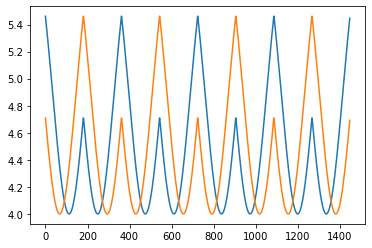

In [7]:
def get_input_vectors(distance,extent=-1):
    r = 1
    o = np.pi/2
    a = np.pi/8
    angles = np.linspace(0,np.pi,181)
    x_coordinates = np.cos(angles) * distance
    y_coordinates = np.sin(angles) * distance
    s1x = r * np.cos(o + a)     # sensor 1 x position
    s1y = r * np.sin(o + a)     # sensor 1 y position
    s2x = r * np.cos(o - a)     # sensor 2 x position
    s2y = r * np.sin(o - a)     # sensor 2 y position
    d1 = np.sqrt((x_coordinates-s1x)**2+(y_coordinates-s1y)**2)
    d2 = np.sqrt((x_coordinates-s2x)**2+(y_coordinates-s2y)**2)
    inputs = np.stack((d1,d2),1)
    inputs = np.concatenate((inputs,np.flip(inputs,axis=1)),0)
    inputs = np.concatenate((inputs,inputs),0)
    inputs = np.concatenate((inputs,inputs),0)
    return inputs[:extent]
#x,y=get_input_vectors(5)
#plt.plot(x,y)
plt.plot(get_input_vectors(5))

In [8]:
def tease_agent(distances=[2],n=2):
    trajectories = []
    agent, mw, sw = get_agent(n)
    N = n
    HN = int(N/2)
    gs = HN * N + HN + N + HN
    alpha_index = 0
    
    for distance in distances:
        inputs = get_input_vectors(distance)

        activations = []
        body = w.Agent(np.ones(gs))
        food = w.Food(0,0)
        agent.initializeState(0)
        for i in range(100):
            agent.step(0.01)
        for inp in inputs:
            agent.Inputs = np.dot(inp,sw)
            agent.step(0.01)
            motorout = np.dot(agent.Outputs,mw)
            body.step(food, motorout, 0.01)
            activations.append(motorout)
            trajectories.append(body.orient())
        activations = np.array(activations)
        plt.plot(activations[:,0],color="blue", label=f"Neuron 1-Distance {distance}",alpha=1-alpha_index)
        plt.plot(activations[:,1],color="orange",label=f"Neuron 2-Distance {distance}",alpha=1-alpha_index)
        alpha_index += 0.2
    plt.legend(bbox_to_anchor=(1.2, 1))
    plt.rcParams["figure.figsize"] = (20,10)
    plt.title("Rotating Light Around Agent")
    plt.ylabel("Neuron Outputs")
    plt.xlabel("Time")
    plt.show()
    return trajectories

In [9]:
def tease_agent_ff(distances=[2],n=2):
    trajectories = []
    agent= get_agent_ff(n)
    N = n
    HN = int(N/2)
    gs = HN * N + HN + N + HN
    alpha_index = 0
    
    for distance in distances:
        inputs = get_input_vectors(distance)

        for inp in inputs:
            out = agent.step(inp)
            trajectories.append(out)
        activations = np.array(trajectories)
        plt.plot(activations[:,0],color="blue", label=f"Neuron 1-Distance {distance}",alpha=1-alpha_index)
        plt.plot(activations[:,1],color="orange",label=f"Neuron 2-Distance {distance}",alpha=1-alpha_index)
        alpha_index += 0.2
    plt.legend(bbox_to_anchor=(1.2, 1))
    plt.rcParams["figure.figsize"] = (20,10)
    plt.title("Rotating Light Around Agent")
    plt.ylabel("Neuron Outputs")
    plt.xlabel("Time")
    plt.show()
    return trajectories

In [18]:
#ts = tease_agent_ff(distances=[5,4,3,2,1],n=32)

### Tease Agents
Tease agents but applied to multiple agents and plots stacked

In [12]:
def tease_agents(distances=[2],ns=[2,4,8,16,32],wait=False):
    fig, axs = plt.subplots(len(ns), sharex=True, sharey=False, figsize=(20,10))
    fig.suptitle('Neural Dynamics')
    for i in range(1,1+len(ns)):
        n = 2 ** i
        agent, mw, sw = get_agent(n)
        N = 2
        HN = int(N/2)
        gs = HN * N + HN + N + HN
        alpha_index = 0

        for distance in distances:
            inputs = get_input_vectors(distance)

            activations = []
            body = w.Agent(np.ones(gs))
            food = w.Food(0,0)
            agent.initializeState(0)
            for j in range(100):
                agent.step(0.01)
            for inp in inputs:
                agent.Inputs = np.dot(inp,sw)
                agent.step(0.01)
                if wait:
                    for j in range(200):
                        agent.step(0.01)
                motorout = np.dot(agent.Outputs,mw)
                body.step(food, motorout, 0.01)
                activations.append(motorout)
            activations = np.array(activations)
            max_speed = np.dot(np.ones(n),mw).sum()
            axs[i-1].plot(activations[:,0],color="blue", label=f"Motor 1-Distance {distance}",alpha=1-alpha_index)
            axs[i-1].plot(activations[:,1],color="orange",label=f"Motor 2-Distance {distance}",alpha=1-alpha_index)
            #axs[i-1].set_ylim([activations[50:].min(),activations[50:].max()])
            alpha_index += 0.3
        if i == 3:
            axs[i-1].set_ylabel("Motor Outputs")
        axs[i-1].set_title(f"{n}-Neurons")

    plt.legend(loc="lower left")
    plt.show()

In [13]:
def tease_agents_ff(distances=[2],ns=[2,4,8,16,32]):
    fig, axs = plt.subplots(len(ns), sharex=True, sharey=False, figsize=(20,10))
    #fig.suptitle('Neural Dynamics')
    for i in range(1,1+len(ns)):
        n = 2 ** i
        agent = get_agent_ff(n)
        alpha_index = 0


        for distance in distances:
            inputs = get_input_vectors(distance)

            activations = []
  
            for inp in inputs:
                out = agent.step(inp)
                activations.append(out)
            activations = np.array(activations)
            axs[i-1].plot(activations[:,0],color="blue", label=f"Motor 1-Out {distance}",alpha=1-alpha_index)
            axs[i-1].plot(activations[:,1],color="orange",label=f"Motor 2-Out {distance}",alpha=1-alpha_index)
            alpha_index += 0.3
        if i == 3:
            axs[i-1].set_ylabel("Motor Outputs")
        axs[i-1].set_title(f"{n}-Neurons")

    plt.legend(loc="lower left")
    plt.show()

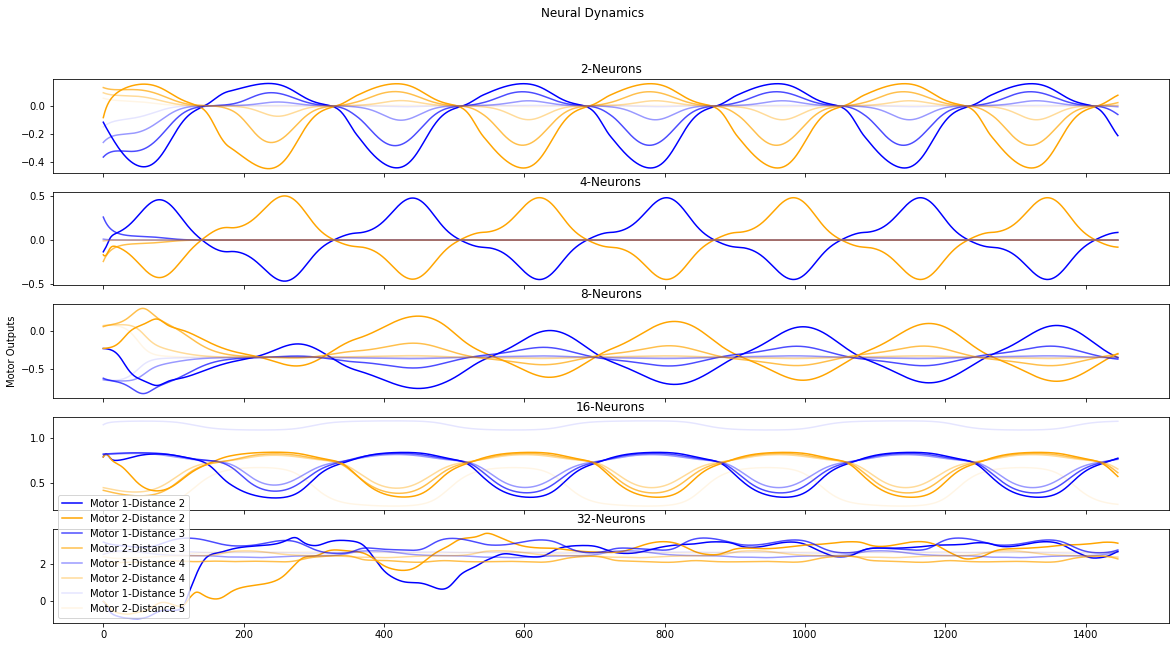

In [15]:
tease_agents(distances=[2,3,4,5])

In [16]:
#tease_agents_ff(distances=[2,3,4,5])

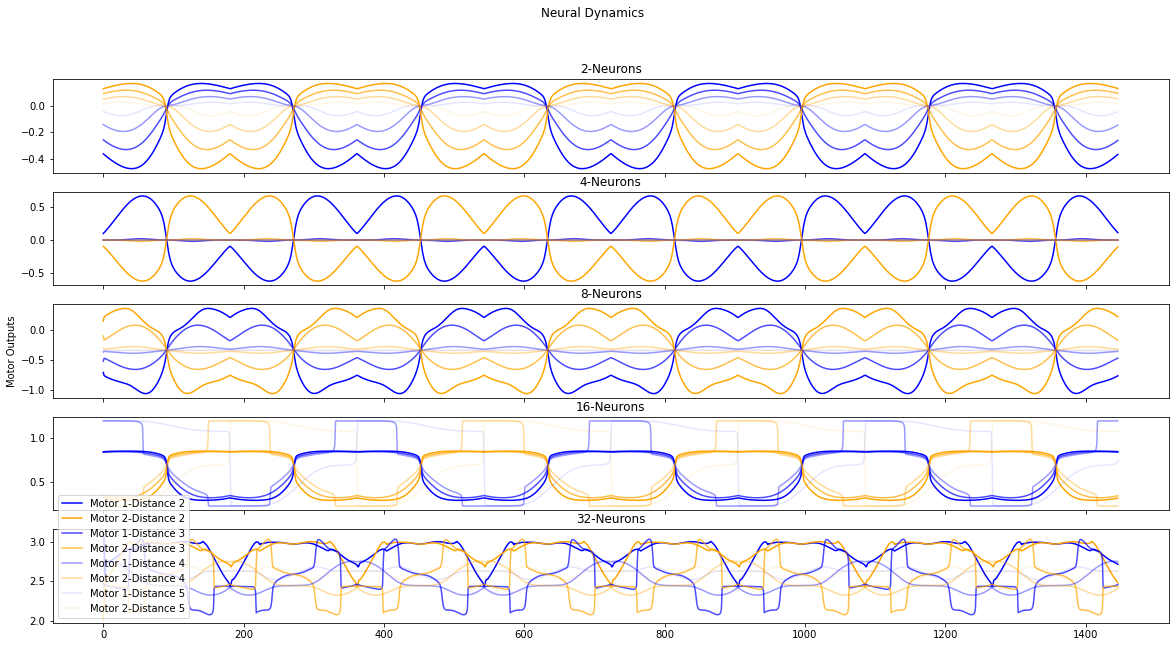

In [17]:
tease_agents(distances=[2,3,4,5],wait=True)

### Get Agent
This function returns the correct agent and its parameters

In [2]:
def get_agent(n=2):
    agent = ctrnn.CTRNN(n)
    agent.load(f"./Run2/{n}_neuron_ctrnn.npz")
    a = np.load(f"./Run2/{n}_neuron_genome.npy")
    count = n/2 * 2
    mw = a[-n:]
    mw = np.stack((mw,np.flip(mw)),axis=1)
    sw = a[-2*n:-n] * 16
    sw = np.stack((sw,np.flip(sw)))
    return agent, mw, sw

In [3]:
def get_agent_ff(n=2):
    agent = feedforward.FeedForwardNetwork(n)
    agent.load(f"./{n}_neuron_ff.npz")
    a = np.load(f"./{n}_neuron_genome.npy")
    return agent

### Get Corelation
Returns correlations between agent behavior and input

In [39]:
for n in [2,4,8,16,32]:
    dist = 5
    angles = np.linspace(0,np.pi,181)
    x_coordinates = np.cos(angles) * dist
    y_coordinates = np.sin(angles) * dist
    
    inputs = get_input_vectors(dist)
    agent = get_agent_ff(n)
    traj = []
    for inp in inputs:
        traj.append(agent.step(inp))
    traj = np.array(traj)
    #plt.plot(traj)
    s1_x = np.corrcoef(traj[:181,0],x_coordinates)
    s1_y = np.corrcoef(traj[:181,0],y_coordinates)
    s2_x = np.corrcoef(traj[:181,1],x_coordinates)
    s2_y = np.corrcoef(traj[:181,1],y_coordinates)
    print(f"N = {n}")
    #print(s1_x,s1_y)
    print(s2_x,s2_y)

N = 2
[[1.         0.91804869]
 [0.91804869 1.        ]] [[1.        0.3547811]
 [0.3547811 1.       ]]
N = 4
[[1.         0.93292778]
 [0.93292778 1.        ]] [[1.         0.25227889]
 [0.25227889 1.        ]]
N = 8
[[ 1.         -0.98979069]
 [-0.98979069  1.        ]] [[1.         0.06465705]
 [0.06465705 1.        ]]
N = 16
[[1.        0.9451326]
 [0.9451326 1.       ]] [[1.         0.21431451]
 [0.21431451 1.        ]]
N = 32
[[1.         0.96388342]
 [0.96388342 1.        ]] [[1.         0.11924306]
 [0.11924306 1.        ]]


### Get Mutual Information

In [40]:
def get_mi_ffn(n=2):
    dist = 5
    angles = np.linspace(0,np.pi,181)
    x_coordinates = np.cos(angles) * dist
    y_coordinates = np.sin(angles) * dist
    
    inputs = get_input_vectors(dist)
    agent = get_agent_ff(n)
    traj = []
    for inp in inputs:
        traj.append(agent.step(inp))
    traj = np.array(traj)
    #plt.plot(traj)
    s1_x = np.corrcoef(traj[:181,0],x_coordinates)
    s1_y = np.corrcoef(traj[:181,0],y_coordinates)
    s2_x = np.corrcoef(traj[:181,1],x_coordinates)
    s2_y = np.corrcoef(traj[:181,1],y_coordinates)
    print(f"N = {n}")
    #print(s1_x,s1_y)
    print(s2_x,s2_y)

### Get Equillibrium Orientation
This function returns the orientating behavior produced by an agent in its equillibrium state (where it could be approximated by a feedforward network.

In [157]:
def eqiullibrium_orientation(n=2,steps=5000):
    inputs = get_input_vectors(2,361)
    agent, mw, sw = get_agent(n)
    rv = []
    for inp in inputs:
        agent.initializeState(0)
        agent.Inputs = np.dot(inp,sw)
        pmo = agent.Outputs
        for step in range(steps):
            agent.step(0.001)
            mo = agent.Outputs
            if (pmo == mo).all():
                break
            else:
                pmo = mo
        mo = np.dot(mo,mw)
        lo = mo[0]
        ro = mo[1]
        rv.append(lo-ro)
    return np.array(rv)
        

r = eqiullibrium_orientation(n=2)

### Orientation Transience
Measures how much the agent orients before it reaches equillibrium. It is normalized by highest response at each distance. 1 - indicates orientation is most prevalent in equillibrium, 0 - indicates orientation is entirely transient and most be studied dynamically.

In [534]:
def orientation_transience(n=2,max_steps=5000,distances=[1,2,3,4,5],step_size=0.001):
    agent, mw, sw = get_agent(n)
    all_rvs = []
    for distance in distances:
        inputs = get_input_vectors(distance,361)
        rv = []
        for inp in inputs:
            agent.initializeState(0)
            agent.Inputs = np.dot(inp,sw)
            pmo = 1
            transients = []
            i = 0
            while True:
                agent.step(step_size)
                mo = agent.Outputs
                to = np.dot(mo,mw)
                transients.append(to[0]-to[1])
                if (pmo - mo < step_size/10).all():
                    break
                else:
                    pmo = mo
                i += 1
                if i == max_steps:
                    break
            transients = np.array(transients)
            mo = np.dot(mo,mw)
            to = mo[0] - mo[1]
            #rv.append(lo-ro)
            #to = np.maximum(0.0001,np.abs(to))
            td = np.abs(transients)
            td_mean = np.log(np.abs(to)/np.maximum(0.00001,td[:i].mean()))
            rv.append(td_mean)
        rv = np.array(rv)
        all_rvs.append(rv)
    all_rvs = np.array(all_rvs)
    all_rvs /= all_rvs.max()
    #all_rvs = np.stack((all_rvs[0:],all_rvs),axis=1)
    return all_rvs

In [529]:
def circle_plot(data,cmap="PiYG"):
    #data = np.stack((data,data),axis=1)
    fig = plt.figure()
    ax = Axes3D(fig)
    print(data.shape)
    if len(data.shape) == 1:
        m = 2
        n = data.shape[0] + 1
        
    else:
        data = np.swapaxes(data,0,1)
        m = data.shape[1] + 1
        n = data.shape[0] + 1
        
    rad = np.linspace(0, data.shape[1], m)
    a = np.linspace(0, 2 * np.pi, n)
    r, th = np.meshgrid(rad, a)

    z = np.random.uniform(-1, 1, (n,m))
    #print(z)
    plt.subplot(projection="polar")

    plt.pcolormesh(th, r, data, cmap=cmap)

    plt.plot(a, r, ls='none', color = 'k') 
    plt.grid()
    plt.colorbar()

In [652]:
orientations = {}

In [531]:
def get_agent_circle(n=2):
    r = eqiullibrium_orientation(n)
    #r = np.stack((r[0],r[0]),axis=1)
    circle_plot(r)
    plt.title(f"Long Term Orientation Response for Agent-{n}")
    plt.show()

def get_agent_circle_transience(n=2,ci=-1):
    
    if n in orientations:
        r = orientations[n]
    else:
        r = orientation_transience(n)
        orientations[n] = r
    colors = ["Wistia","YlGnBu_r","hot","summer","winter","cool","bone","YlOrBr","autumn","plasma","inferno"]
    circle_plot(r,cmap=colors[ci])
    plt.title(f"Feedforwardness of Orientation Response for Agent-{n}")
    plt.show()
    

<ipython-input-528-2a5a0e133fad>:31: RuntimeWarning: divide by zero encountered in log
  td_mean = np.log(np.abs(to)/np.maximum(0.00001,td[:i].mean()))


(5, 361)


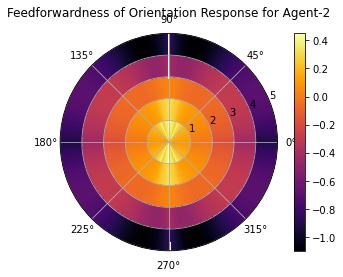

<ipython-input-528-2a5a0e133fad>:31: RuntimeWarning: divide by zero encountered in log
  td_mean = np.log(np.abs(to)/np.maximum(0.00001,td[:i].mean()))


(5, 361)


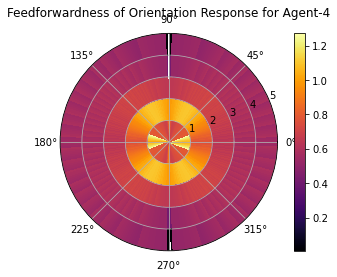

(5, 361)


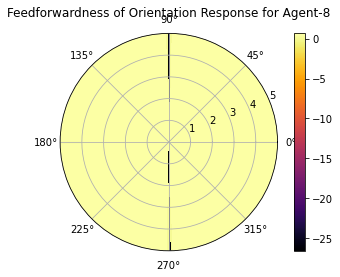

<ipython-input-528-2a5a0e133fad>:31: RuntimeWarning: divide by zero encountered in log
  td_mean = np.log(np.abs(to)/np.maximum(0.00001,td[:i].mean()))


(5, 361)


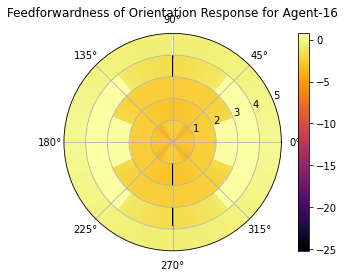

<ipython-input-528-2a5a0e133fad>:31: RuntimeWarning: divide by zero encountered in log
  td_mean = np.log(np.abs(to)/np.maximum(0.00001,td[:i].mean()))


(5, 361)


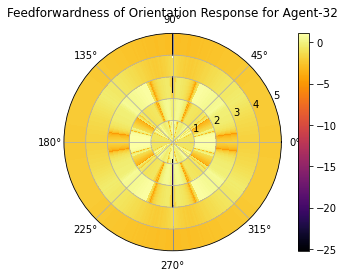

In [532]:
for i in [2,4,8,16,32]:
    get_agent_circle_transience(n=i,ci=10)

In [ ]:
for i in [2,4,8,16,32]:
    get_agent_circle_transience(n=i,ci=10)

In [783]:
def get_transience(timeseries,dx=0.0001):
    # Iterate through time series and identify equillibria
    prev_point = -1
    counter = 0
    for point in timeseries:
        if np.abs(point - prev_point) < 0.0001:
            break
        prev_point = point
        counter += 1
    
    #An equillibrium is never reached
    if counter == timeseries.shape[0]:
        return 0
    
    transient = timeseries[:counter]
    
    transient_volume = np.maximum(0.000001,np.trapz(transient,dx=dx))
    equillibrium_volume = dx * counter * point
    rv = equillibrium_volume/transient_volume
    return rv

In [790]:
def get_all_transiences(index,dx=0.0001):
    trajs = trajs_s[index]
    rv = []
    for di, trials in enumerate(trajs):
        rv.append([])
        for ai, run in enumerate(trials):
            t = np.abs(run[:,0] - run[:,1])
            rv[-1].append(get_transience(t))
    rv = np.array(rv)
    return rv/rv.max()

In [791]:
get_all_transiences(1).shape

(4, 361)

In [796]:
def get_agent_circle_transience(n=2,ci=-1):
    if n in orientations:
        r = orientations[n]
    else:
        r = get_all_transiences(n)
        orientations[n] = r
    colors = ["Wistia","YlGnBu_r","hot","summer","winter","cool","bone","YlOrBr","autumn","plasma","inferno"]
    circle_plot(r,cmap=colors[ci])
    plt.title(f"Intransience of Orientation Response for Agent-{2**n}")
    plt.show()

(4, 361)


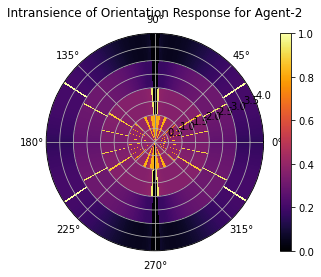

(4, 361)


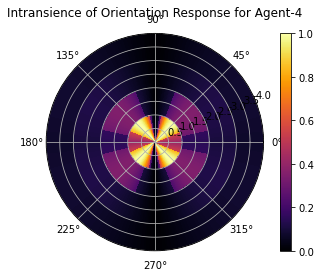

(4, 361)


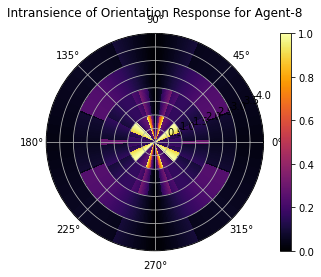

(4, 361)


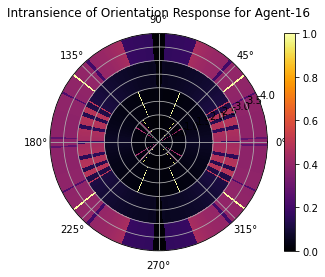

(4, 361)


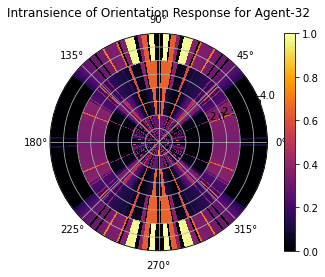

In [797]:
for i in range(1,6):
    get_agent_circle_transience(i)

In [789]:
orientations[1].max()

2.5792406784329525

In [792]:
orientations = {}